In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
from IPython.display import display, Math, Latex
from __future__ import print_function
from __future__ import division

# Non-Linear Signal Processing: Exercise 9

This exercise is based on C. M. Bishop: *Pattern Recognition
and Machine Learning*, section~2.5.

Print and comment on the figures produced by the software as outlined below at the **Checkpoints**.

## Probability density function estimation using a kernel smoother
A training set of N data points $D=\{\mathbf x_1,\mathbf x_2,..,\mathbf x_N\}$ is
extrapolated "smoothened"  to test points $\mathbf x$
\begin{equation}
    p(\mathbf x|D,h) = \frac{1}{N} \sum_{n=1}^{N} k(\mathbf x|\mathbf x_n,h)
\end{equation}
with a "kernel" $k(\mathbf x|\mathbf x_n,h)$ given eg. by
\begin{eqnarray}
k(\mathbf x|\mathbf x_n,h) &=& \left(\frac{1}{2\pi h^2}\right)^{d/2} \exp
\left(-\frac{1}{2h^2}(\mathbf x-\mathbf x_n)^2\right)\nonumber
\end{eqnarray}
where the dimension of $\mathbf x$ is $d$.
The parameter $h$ acts as a smoothing control. If
$h$ is small we roughly get a set of local `delta functions' centered on the training
data set, if $h$, on the other hand, is very large we get a near-uniform distribution.


### Checkpoint 9.1
We will use a validation set  - a test set for tuning of parameters - of $M$ samples to find $h$.
Explain why the function
\begin{equation}
    E(h)= \frac{1}{M}\sum_{m=1}^{M} -\log p(\mathbf x_m|D,h) = \frac{1}{M}\sum_{m=1}^{M} -\log \frac{1}{N}\sum_{n=1}^{N} k(\mathbf x_m|\mathbf x_n,h)
\end{equation}
is a "test error". Use the cells below to generate data from a normal distribution
in $d=2$. What is the optimal $h$ for this data set?
Explain the structure of the densities obtained by the "optimal" $h$,
and $h$'s that are too small and too big.

How does the optimal $h$ depend on the training sample size $N$?


In [12]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

In [38]:
Nx=50          # dimensions of 2D data 
Ny=50
N=300          # training set size
Nval=200       # test set size
width=10       # std of simulation normal distribution

# Normal distributed data for training set
xtrain=(Nx/2)+ width*np.random.randn(N,1)
ytrain=(Ny/2)+ width*np.random.randn(N,1)
Ztrain=np.c_[xtrain,ytrain]

In [60]:
# Evaluate the density in grid for visualization
xtest=np.repeat(np.linspace(1,Nx,Nx)[:,None],Ny,axis=1)
ytest=np.repeat(np.linspace(1,Ny,Ny)[:,None],Nx,axis=1)
Ztest=np.c_[xtest.flatten(),ytest.flatten(order='F')]

In [40]:
# validation set for tuning of h
# Normal distributed data for training set
xval=(Nx/2)+ width*np.random.randn(Nval,1)
yval=(Ny/2)+ width*np.random.randn(Nval,1)
Zval=np.c_[xval,yval]
# tune h between limits
Nh=20
hmax=100
hmin=1
harray=np.linspace(hmin,hmax,Nh)

In [41]:
def kpdf(xtrain,h,xtest):
    '''
    Parzen window kernel pdf estimator
    INPUT:
        xtrain    [N1,D] training set
        h          variance of gaussian kernel
        xtest     [N2,D] test input
    OUTPUT:
        estpdf    estimated pdf values at xtest points
    '''
    assert xtrain.shape[1] == xtest.shape[1], 'Dimensional mismatch between train and test input'
    sum_of_squares_train = (xtrain**2).sum(1)
    sum_of_squares_test = (xtest**2).sum(1)
    # compute N1*N2 distance matrix
    distmat = sum_of_squares_train[:,None]+sum_of_squares_test[:,None].T-2*np.dot(xtrain,xtest.T)
    alpha = 1/h
    expdistmat = (alpha/(2*np.pi))**(xtrain.shape[1]/2)*np.exp(-.5*alpha*distmat.T)
    estpdf = expdistmat.mean(1)
    return estpdf

In [42]:
err = []
for n in range(Nh):
    estpdf=kpdf(Ztrain,harray[n],Zval)
    err.append(-np.log(estpdf).mean())

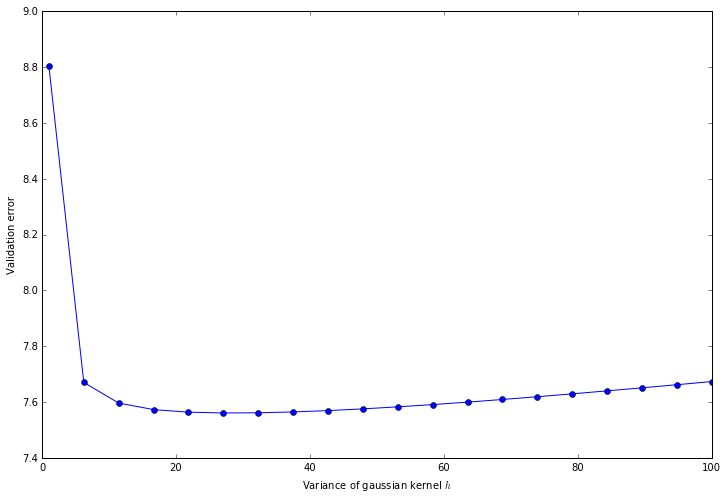

In [43]:
plt.plot(harray,err,'o-')
plt.xlabel('Variance of gaussian kernel $h$')
plt.ylabel('Validation error');

In [110]:
h_opt = np.min(err)

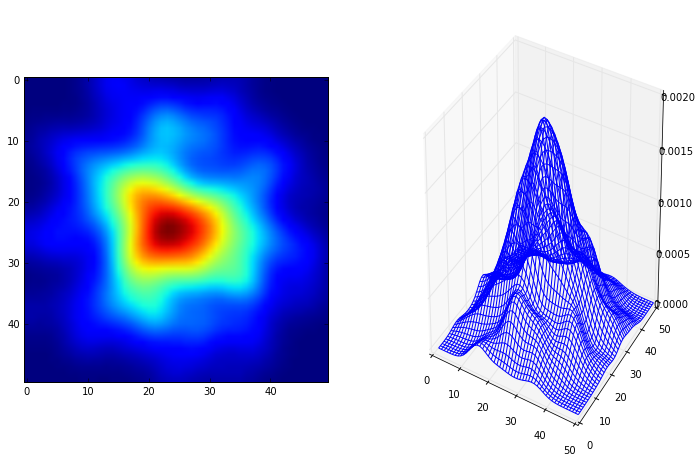

In [111]:
estpdf = kpdf(Ztrain,h_opt,Ztest)
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(np.reshape(estpdf,(Nx,Ny)))
ax = fig.add_subplot(122, projection='3d')
ax.plot_wireframe(*np.meshgrid(np.linspace(1,Nx,Nx),np.linspace(1,Ny,Ny)),np.reshape(estpdf,(Nx,Ny)));

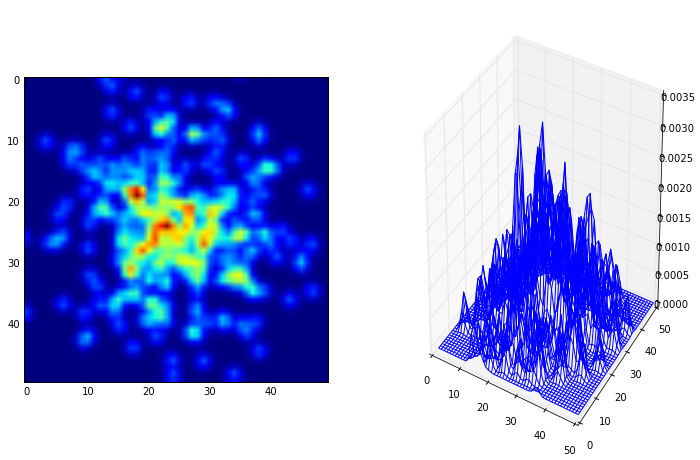

In [112]:
estpdf = kpdf(Ztrain,.1*h_opt,Ztest)
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(np.reshape(estpdf,(Nx,Ny)))
ax = fig.add_subplot(122, projection='3d')
ax.plot_wireframe(*np.meshgrid(np.linspace(1,Nx,Nx),np.linspace(1,Ny,Ny)),np.reshape(estpdf,(Nx,Ny)));

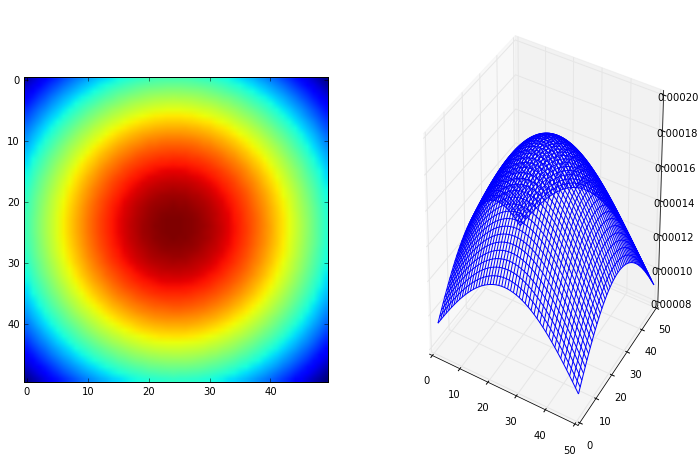

In [113]:
estpdf = kpdf(Ztrain,100*h_opt,Ztest)
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(np.reshape(estpdf,(Nx,Ny)))
ax = fig.add_subplot(122, projection='3d')
ax.plot_wireframe(*np.meshgrid(np.linspace(1,Nx,Nx),np.linspace(1,Ny,Ny)),np.reshape(estpdf,(Nx,Ny)));

## Signal detection using nearest neighbor methods
We will use nearest neighbor methods for non-parametric classification.
Assume that a training set with $N$ class labeled samples is given.

In the K-nearest-neighbor (KNN) classifier we classify test points $\mathbf x$ by voting among
the $K$ nearest neighbors in the training set. We implement this by brute force, i.e., simply by computing the
distance from the test point to all training points and sorting the distances.

A so-called "leave one out" estimate of the classification test error
can be obtained by computing the distances from every training point
to its $K$ neighbors (not including itself!)
and in turn estimate the classification error of the voting result
among the neighbors relative to the given training point's label.



## Pima indian data set

This is a data set where the task is to classify a
population of women according to the risk of diabetes (binary classification).
There are 7 input variables, 200 training examples and 332 test
examples. 68 (34\%) in the training set and 109 (32.82\%) in the test
set have been diagnosed with diabetes.
In Brian Ripley's textbook *Pattern Recognition and Neural Networks* he
states that his best method obtains about 20\% misclassifications on the test data set.
The input variables are:

1. Number of pregnancies
1. Plasma glucose concentration
1. Diastolic blood presure
1. Triceps skin fold thickness
1. Body mass index (weight/height$^2$)
1. Diabetes pedigree function
1. Age

The target output is $1$ for examples diagnosed as diabetes, and $2$ for healthy subjects.

### Checkpoint 9.2
Explain how the "leave one out" error can be used for identifying the optimal number
of neighbors for voting. Use the cells below
to classify the diabetes diagnosis data set.
What is the optimal $K$? How good is the KNN performance compared
to neural networks and other methods considered earlier in the course.

Consider classification from a subset of the seven input variable measures.
Estimate the performance for a few subsets, can you find a subset
with performance equal or better than that of the full feature set?

In [1]:
from scipy.io import loadmat

In [6]:
pima = loadmat("pima.mat")
X_te, y_te, X_tr, y_tr = pima['X_te'],pima['y_te'],pima['X_tr'],pima['y_tr']

In [7]:
subset = [0,1,2,3,4,5,6] # remember python has 0-indexing
X_te = X_te[:,subset]
X_tr = X_tr[:,subset]

In [8]:
Kmax = 120
X_te -= X_te.mean(0)
X_tr -= X_tr.mean(0)
X_te /= X_te.std(0)
X_tr /= X_tr.std(0)

In [115]:
def multiclass_knn(xtrain,ytrain,xtest,K):
    C = np.unique(ytrain).shape[0]
    assert xtrain.shape[1] == xtest.shape[1], 'Dimensional mismatch between train and test input'
    sum_of_squares_train = (xtrain**2).sum(1)
    sum_of_squares_test = (xtest**2).sum(1)
    # compute N1*N2 distance matrix
    distmat = (sum_of_squares_train[:,None]+sum_of_squares_test[:,None].T-2*np.dot(xtrain,xtest.T)).T
    # compute N1*N1 distance matrix
    distmat_train = sum_of_squares_train[:,None]+sum_of_squares_train[:,None].T-2*np.dot(xtrain,xtrain.T)
    idx = np.argsort(distmat)
    idx_train = np.argsort(distmat_train)
    labels = np.zeros((ytrain.shape[0],C))
    labels[np.arange(ytrain.shape[0]),ytrain.astype(np.int).flatten()-1] = 1
    error_array = np.zeros(K)
    for k in range(K):
        looclass1 = [np.argmax(labels[idx_train[n,range(1,k+2)],:].sum(0)) for n in range(xtrain.shape[0])]
        error_array[k] = ((ytrain-1).flatten()!=looclass1).mean()
    Kopt = np.argmin(error_array)+1
    ytest_hat = [np.argmax(labels[idx[n,range(Kopt)],:].sum(0)) for n in range(xtest.shape[0])]
    looclass1 = [np.argmax(labels[idx_train[n,range(2,Kopt+1)],:].sum(0)) for n in range(xtrain.shape[0])]
    return looclass1, ytest_hat, Kopt, error_array

In [116]:
looclass1, ytest_hat, Kopt, error_array = multiclass_knn(X_tr,y_tr,X_te,Kmax)

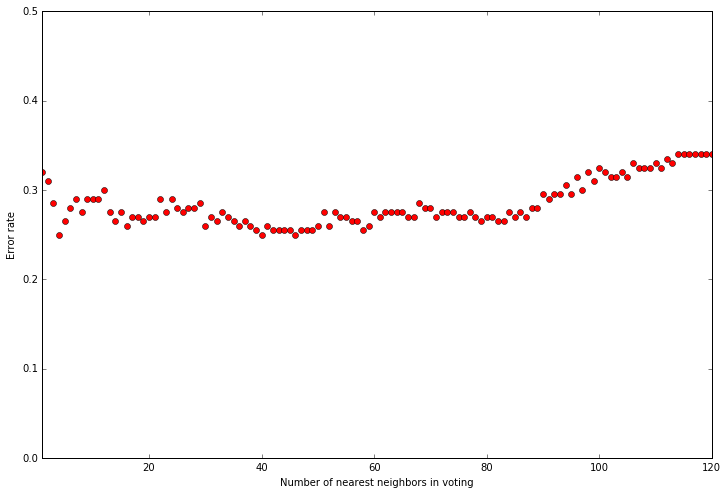

In [129]:
plt.plot(range(1,Kmax+1),error_array,'ro')
plt.ylim(0,.5)
plt.xlim(1,Kmax)
plt.xlabel("Number of nearest neighbors in voting")
plt.ylabel("Error rate");

In [126]:
errtest = ((y_te-1).flatten()!=ytest_hat).mean()

## Local linear regression among nearest neighbors

We can design a non-parametric function approximation scheme by
performing linear regression among the K-nearest neighbors. We apply the method
to prediction of the sunspot test data set.

We use the linear model from exercise 3 and 4 to perform the estimation
in the test set.

### Checkpoint 9.3
Inspect the cells below. Explain the role of the parameter "alpha".
Why is it necessary to regularize the linear model?
What is the meaning of the parameter $d$ and what is optimal value of $d$. 
Make a drawing that explains the algorithm conceptually, e.g.,  in a case with two-dimensional input.

Compare the  quality of the algorithm's predictions with
the neural network based predictions we found in exercise 5. What would happen if we used $K = N_{train}$?.

In [132]:
d = 11
S = np.fromfile('sp.dat',sep='\t')
year, S = S.reshape(-1,2).T
last_train = 221-d
N = S.shape[0]-d
T = S[d:]
X = np.array([S[i:N+i] for i in range(d)]).T
X = np.c_[np.ones(N,),X]
Xtrain = X[:last_train,:]
Xtest = X[last_train:,:]
Ttrain = T[:last_train]
Ttest = T[last_train:]
var = T.var(ddof=1)

In [194]:
#xtrain,ytrain,xtest,K,alpha = Xtrain, Ttrain, Xtest, 150, 0.001
def knn_regression(xtrain,ytrain,xtest,K,alpha):
    y_test_hat = np.zeros(xtest.shape[0])
    for j in range(xtest.shape[0]):
        delta = xtrain[:,1:]-xtest[j,1:]
        dist = (delta**2).sum(1)
        idx = np.argsort(dist)
        X = xtrain[idx[:K],:]
        w = np.dot(np.linalg.inv(np.dot(X.T,X)+alpha*np.eye(xtrain.shape[1])),np.dot(X.T,ytrain[idx[:K]]))
        y_test_hat[j] = np.dot(xtest[j,:],w)    
    return y_test_hat

In [200]:
Kmax = 150
alpha = 0.001
error = np.zeros(Kmax)
for k in range(1,Kmax):
    ypred = knn_regression(Xtrain, Ttrain, Xtest, k, alpha)
    error[k-1] = ((ypred-Ttest)**2).sum()/(Ttest.shape[0]*var)

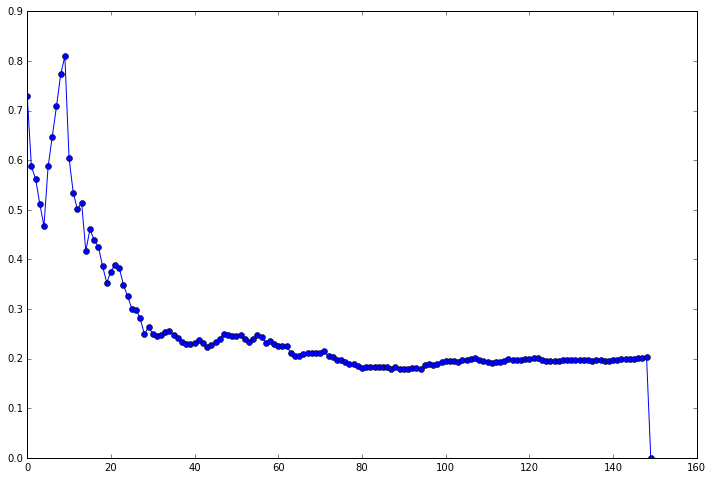

In [203]:
plt.plot(np.arange(Kmax),error,'o-');
plt.xlim(0,1)

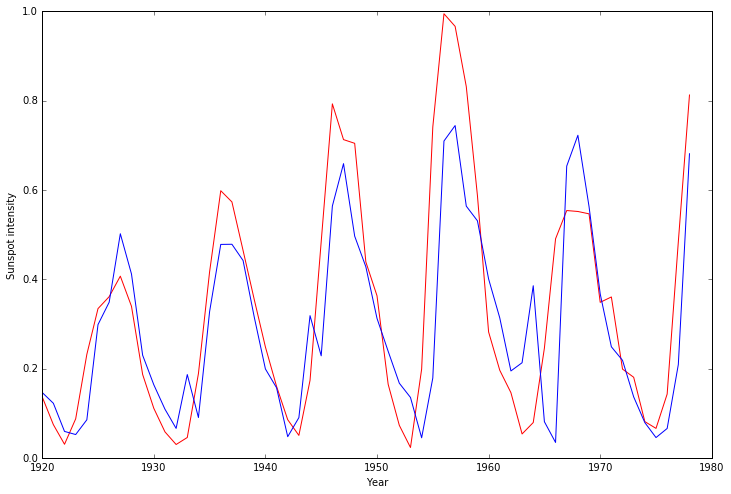

In [190]:
plt.plot(1920+np.arange(y_test_hat.shape[0]),Ttest,color='r',linestyle='-')
plt.plot(1920+np.arange(y_test_hat.shape[0]),y_test_hat,color='b',linestyle='-')
plt.xlabel('Year')
plt.ylabel('Sunspot intensity');